# Multi-Component Gravitational Lenses — Amplification Factor

This notebook demonstrates gravitational lensing by three types of multi-component lens
systems using FIONA's `FresnelNUFFT3` solver:

1. **4 CIS sub-lenses placed symmetrically** around the origin (Section 1).
2. **4 SIS sub-lenses placed randomly** (Section 2).
3. **10 SIS sub-lenses placed randomly** (Section 3).

Two complementary visualisations are produced for each case:

- **2-D magnification maps** — $|F(\omega, \mathbf{y})|$ over the source plane for
  several dimensionless frequencies $\omega$.
- **$|F(\omega)|$ vs $\omega$ curves** — the amplification factor as a function of
  frequency at a set of fixed source positions.

## Environment Setup

FIONA caches 2-D Gauss–Legendre quadrature grids on disk.  
Set `FIONA_GL2D_DIR` to a writable directory **before** importing FIONA so the cache is
found (or created) correctly.  
Adjust the path and thread counts to match your hardware.

In [1]:
%matplotlib inline

import os
os.environ["FIONA_GL2D_DIR"] = os.environ.get(
    "FIONA_GL2D_DIR",
    "/n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d"
)
os.environ["FIONA_GL2D_STRICT"] = os.environ.get("FIONA_GL2D_STRICT", "0")
os.environ["OMP_NUM_THREADS"] = os.environ.get("OMP_NUM_THREADS", "112")

## Imports

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from fiona import CIS, SIS, set_num_threads, FresnelNUFFT3
from fiona.utils import spline_fit_eval

# Use up to 112 threads (adjust to your hardware)
set_num_threads(112)

## 1. Four CIS Sub-lenses — Symmetric Configuration

### 1.1 Lens model

The `FourCISLens` class places four Curved Isothermal Sphere (CIS) sub-lenses at the
four cardinal points $(\pm\text{offset},\ 0)$ and $(0,\ \pm\text{offset})$, forming a
perfectly symmetric cross configuration.  Each sub-lens shares the same potential
strength $\psi_0$ and core radius $x_c$.

In [3]:
class FourCISLens:
    def __init__(self, psi0=1.0, xc=0.05, offset=0.5):
        self.lenses = [
            CIS(psi0=psi0, xc=xc),
            CIS(psi0=psi0, xc=xc),
            CIS(psi0=psi0, xc=xc),
            CIS(psi0=psi0, xc=xc),
        ]
        self.offsets = [
            ( offset, 0.0),
            (-offset, 0.0),
            (0.0,  offset),
            (0.0, -offset),
        ]

    def psi_xy(self, x1, x2):
        psi = 0.0
        for lens, (dx, dy) in zip(self.lenses, self.offsets):
            psi = psi + lens.psi_xy(x1 - dx, x2 - dy)
        return psi

### 1.2 2-D Magnification Maps

#### Helper function

Computes $|F(\omega, \mathbf{y})|$ on a 2-D grid for a sweep over core radii $x_c$
(rows) and dimensionless frequencies $\omega$ (columns).  All frequencies for a given
lens are evaluated in a single `FresnelNUFFT3` call.  Each row shares a single colour
scale for easy comparison across frequencies.

In [4]:
def plot_fourCIS_w_grid_row_colorbars(
    psi0=1.0,
    xc_list=(0.02, 0.05, 0.1),
    offset=0.5,
    w_list=(1.0, 10.0, 100.0),
    gl_nodes_per_dim=5000,
    min_physical_radius=10.0,
    nufft_tol=1e-13,
    numexpr_nthreads=64,
    y_extent=1.5,
    Ny=500,
    Nx=500,
    cmap="magma",
    font_size=17,
    verbose=False,
):
    plt.rcParams.update({
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "font.size": font_size,
    })

    xc_list = list(xc_list)
    w_list = np.asarray(w_list, dtype=float)

    # y-grid
    y1 = np.linspace(-y_extent, y_extent, Nx)
    y2 = np.linspace(-y_extent, y_extent, Ny)
    Y1, Y2 = np.meshgrid(y1, y2, indexing="xy")
    y1_targets = Y1.ravel()
    y2_targets = Y2.ravel()

    fig, axes = plt.subplots(
        len(xc_list),
        len(w_list),
        figsize=(5 * len(w_list), 5 * len(xc_list)),
        constrained_layout=True,
        squeeze=False,
    )

    for i, xc in enumerate(xc_list):
        lens = FourCISLens(psi0=psi0, xc=xc, offset=offset)

        nu3 = FresnelNUFFT3(
            lens,
            gl_nodes_per_dim=gl_nodes_per_dim,
            min_physical_radius=min_physical_radius,
            nufft_tol=nufft_tol,
            auto_R_from_gl_nodes=True,
            use_tail_correction=True,
            window_potential=True,
            window_u=True,
            coordinate_system="cartesian",
            numexpr_nthreads=numexpr_nthreads,
            verbose=verbose,
        )

        F = nu3(w_list, y1_targets, y2_targets, verbose=False)
        Fabs = np.abs(F)

        # Row-wise normalization
        norm = Normalize(vmin=float(Fabs.min()), vmax=float(Fabs.max()))

        ims = []
        for j, w in enumerate(w_list):
            frame = Fabs[j].reshape(Ny, Nx)
            ax = axes[i, j]

            im = ax.imshow(
                frame,
                origin="lower",
                extent=[y1.min(), y1.max(), y2.min(), y2.max()],
                norm=norm,
                aspect="equal",
                cmap=cmap,
            )
            ims.append(im)

            if i == 0:
                ax.set_title(rf"$\omega={w:g}$")
            else:
                ax.set_ylabel("")

            ax.set_xlabel(r"$y_1$")

            xticks = np.arange(np.ceil(-y_extent), np.floor(y_extent) + 1, 1)
            yticks = np.arange(np.ceil(-y_extent), np.floor(y_extent) + 1, 1)
            ax.set_xticks(xticks)
            ax.set_yticks(yticks)

        cbar = fig.colorbar(
            ims[-1],
            ax=axes[i, :],
            shrink=0.95,
            pad=0.02,
        )
        cbar.set_label(r"$|F(\omega,\mathbf{y})|$")

    plt.show()

#### Generate the maps

Four CIS sub-lenses are placed symmetrically at distance `offset = 2.0` from the origin
with core radius $x_c = 0.05$.  The amplification factor is evaluated on a 500 × 500
grid for $\omega \in \{1, 10, 100\}$.

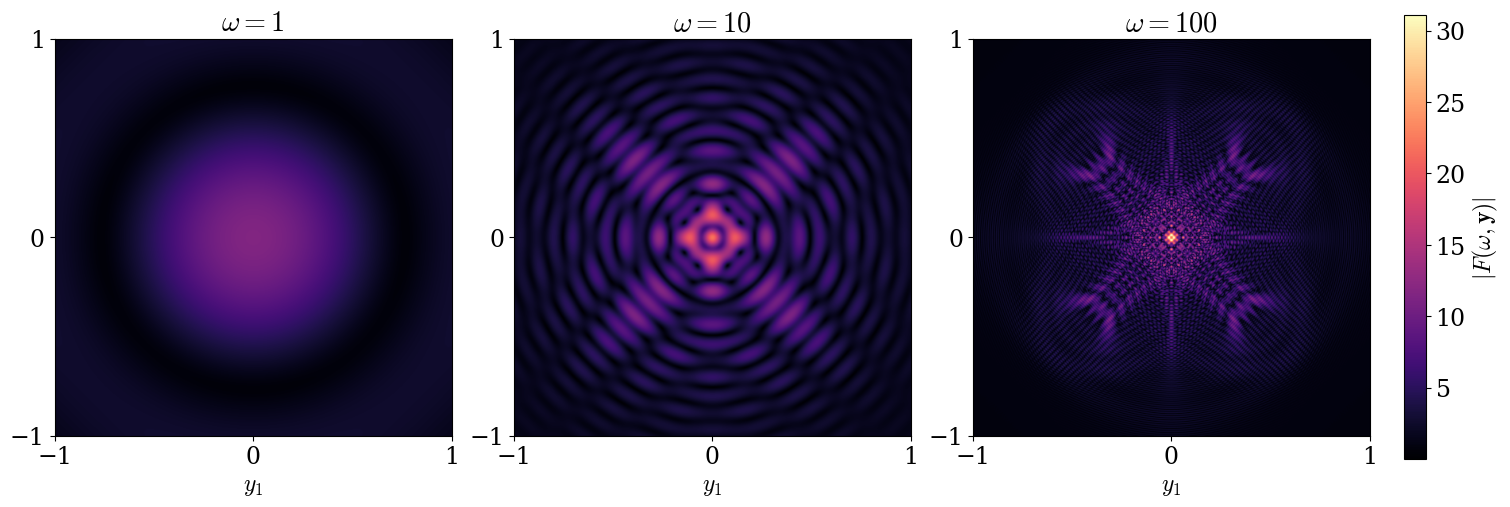

In [5]:
plot_fourCIS_w_grid_row_colorbars(
    psi0=1.0,
    xc_list=(0.05,),
    offset=2.0,
    w_list=(1.0, 10.0, 100.0),
    gl_nodes_per_dim=5000,
    min_physical_radius=10.0,
    nufft_tol=1e-13,
    numexpr_nthreads=64,
    y_extent=1.,
    Ny=500,
    Nx=500,
    cmap="magma",
    font_size=17,
    verbose=False,
)

### 1.3 $|F(\omega)|$ vs $\omega$ at Fixed Source Positions

#### Helper function

Evaluates $F(\omega)$ over a dense frequency grid at source positions $(y_\star, 0)$
and plots the absolute amplification factor.  A spline is fitted to the computed
samples when `spline=True` for a smooth rendering.

In [6]:
def plot_four_cis_Fw_vs_w_panel(
    y_stars=(0.3, 0.6, 0.9),
    w_grid=np.linspace(0.1, 100.0, 100),
    psi0=1.0,
    xc=0.05,
    offset=2.0,
    # computation settings
    gl_nodes_per_dim=4000,
    min_physical_radius=100.0,
    nufft_tol=1e-9,
    auto_R_from_gl_nodes=True,
    use_tail_correction=True,
    window_potential=True,
    window_radius_fraction=0.75,
    window_u=True,
    window_u_width=0.02,
    coordinate_system="cartesian",
    numexpr_nthreads=1,
    parallel_frequencies=True,
    nufft_workers=112,
    nufft_nthreads=1,
    nufft_tile_max_points=4000**2,
    nufft_tile_autotune=True,
    nufft_tile_candidates=(500000, 1000000, 2000000, 4000000, 6000000, 8000000),
    # plotting
    spline=True,
    spline_method="smooth",
    spline_s=None,
    fine_factor=10,
    font_size=15,
):
    lens = FourCISLens(psi0=psi0, xc=xc, offset=offset)

    nu3 = FresnelNUFFT3(
        lens,
        gl_nodes_per_dim=gl_nodes_per_dim,
        min_physical_radius=min_physical_radius,
        nufft_tol=nufft_tol,
        auto_R_from_gl_nodes=auto_R_from_gl_nodes,
        use_tail_correction=use_tail_correction,
        window_potential=window_potential,
        window_radius_fraction=window_radius_fraction,
        window_u=window_u,
        window_u_width=window_u_width,
        coordinate_system=coordinate_system,
        numexpr_nthreads=numexpr_nthreads,
        parallel_frequencies=parallel_frequencies,
        nufft_workers=nufft_workers,
        nufft_nthreads=nufft_nthreads,
        nufft_tile_max_points=nufft_tile_max_points,
        nufft_tile_autotune=nufft_tile_autotune,
        nufft_tile_candidates=nufft_tile_candidates,
        use_type1_grid=False,   # force Type-3
        verbose=True,
    )

    y1 = np.asarray(y_stars, dtype=float)
    y2 = np.zeros_like(y1)

    # Shape: (n_w, n_y)
    F_fiona = nu3(w_grid, y1, y2)

    plt.rcParams.update({
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "font.size": font_size,
    })

    fig, axes = plt.subplots(1, len(y_stars), figsize=(5 * len(y_stars), 4), constrained_layout=True)
    if len(y_stars) == 1:
        axes = [axes]

    ws = np.asarray(w_grid)
    for i, y_star in enumerate(y_stars):
        mag_fiona = np.abs(F_fiona[:, i])

        # Guard against NaNs/inf before spline
        mask = np.isfinite(ws) & np.isfinite(mag_fiona)
        ws_m = ws[mask]
        mag_m = mag_fiona[mask]

        ax = axes[i]
        if spline and ws_m.size >= 4:
            wmin, wmax = float(np.min(ws_m)), float(np.max(ws_m))
            n_fine = max(int(len(ws_m) * fine_factor), 200)
            ws_fine = np.linspace(wmin, wmax, n_fine)
            mag_s = spline_fit_eval(ws_m, mag_m, ws_fine, method=spline_method, smooth_s=spline_s)
            ax.plot(ws_fine, mag_s, "-", label="FIONA", color="teal")
        else:
            ax.plot(ws_m, mag_m, "-", label="FIONA", color="teal")

        ax.set_xlabel(r"$\omega$")
        if i == 0:
            ax.set_ylabel(r"$|F(\omega)|$")
        ax.set_title(rf"$y=({y_star}, 0)$")
        ax.legend(loc="upper right")

    plt.show()

#### Generate the $|F(\omega)|$ curves

The amplification factor is computed at source positions $y \in \{0.5, 1.0, 2.0\}$
for 560 frequencies between $\omega = 0.1$ and $\omega = 10$.

[numexpr] using 1 threads (requested=1, MAX=1, cores=112)
[FresnelNUFFT3] x-domain path
  input prep:      0.0001s
  grouping:        0.0024s | groups=6
  adaptive R/h:  R in [7.07739, 70.7107] | n_gl in [1000, 6000], h in [0.0444288, 0.443892]
  quadrature:      0.3008s
  lens + base:     0.0000s
  scaling:         0.0000s
  alloc out:       0.0000s
  NUFFT total:    54.6000s
  tiling:        adaptive (tiles in [1, 72], max_points=16000000)
  workers:       up to 112 (nufft_nthreads=1)
  wall total:     60.1730s


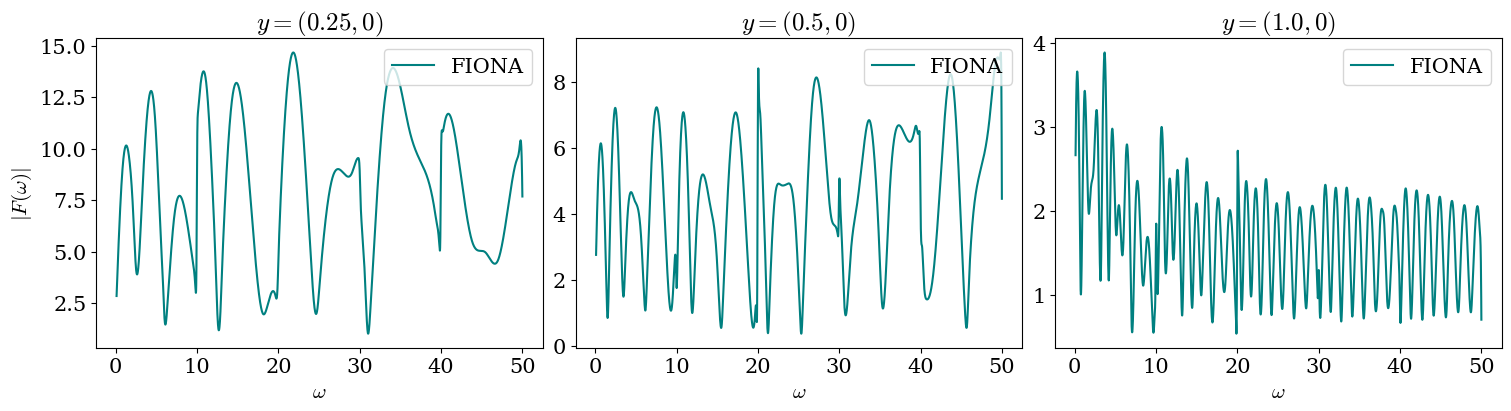

In [16]:
plot_four_cis_Fw_vs_w_panel(
    y_stars=(0.25, 0.5, 1.),
    w_grid=np.linspace(0.1, 50.0, 560),
    psi0=1.0,
    xc=0.05,
    offset=2.0,
)

## 2. Random SIS Sub-lenses

### 2.1 Lens model

The `RandomSISLens` class places `n` SIS sub-lenses at random positions drawn from a
uniform square of half-width `spread`, centres them on their centre of mass, and sums
their lensing potentials.

In [8]:
class RandomSISLens:
    def __init__(self, n=10, psi0=1.0, spread=0.8, seed=123):
        rng = np.random.default_rng(seed)
        self.n = n
        self.psi0 = psi0
        positions = rng.uniform(-spread, spread, size=(n, 2))

        com = positions.mean(axis=0)
        self.positions = positions - com

        self.lenses = [SIS(psi0=psi0) for _ in range(n)]

    def psi_xy(self, x1, x2):
        psi = 0.0
        for lens, (dx, dy) in zip(self.lenses, self.positions):
            psi = psi + lens.psi_xy(x1 - dx, x2 - dy)
        return psi

### 2.2 2-D Magnification Maps

#### Helper function

Computes $|F(\omega, \mathbf{y})|$ on a regular 2-D grid for multiple lens spreads
(rows) and frequencies (columns).  Each row shares a single colour scale so brightness
can be compared across frequencies.

In [9]:
def plot_randomSIS_w_grid_row_colorbars(
    n_sis=10,
    psi0=1.0,
    spread_list=(0.4, 0.8, 1.2),
    seed=123,
    w_list=(1.0, 10.0, 100.0),
    gl_nodes_per_dim=5000,
    min_physical_radius=10.0,
    nufft_tol=1e-13,
    numexpr_nthreads=64,
    y_extent=1.5,
    Ny=500,
    Nx=500,
    cmap="magma",
    font_size=17,
    verbose=False,
):
    plt.rcParams.update({
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "font.size": font_size,
    })

    spread_list = list(spread_list)
    w_list = np.asarray(w_list, dtype=float)

    y1 = np.linspace(-y_extent, y_extent, Nx)
    y2 = np.linspace(-y_extent, y_extent, Ny)
    Y1, Y2 = np.meshgrid(y1, y2, indexing="xy")
    y1_targets = Y1.ravel()
    y2_targets = Y2.ravel()

    fig, axes = plt.subplots(
        len(spread_list),
        len(w_list),
        figsize=(5 * len(w_list), 5 * len(spread_list)),
        constrained_layout=True,
        squeeze=False,
    )

    for i, spread in enumerate(spread_list):
        lens = RandomSISLens(n=n_sis, psi0=psi0, spread=spread, seed=seed)

        nu3 = FresnelNUFFT3(
            lens,
            gl_nodes_per_dim=gl_nodes_per_dim,
            min_physical_radius=min_physical_radius,
            nufft_tol=nufft_tol,
            auto_R_from_gl_nodes=True,
            use_tail_correction=True,
            window_potential=True,
            window_u=True,
            coordinate_system="cartesian",
            numexpr_nthreads=numexpr_nthreads,
            verbose=verbose,
        )

        Fabs_list = []
        row_min = np.inf
        row_max = -np.inf

        for w in w_list:
            t_sub0 = time.perf_counter()
            Fw = nu3(np.array([w]), y1_targets, y2_targets, verbose=False)
            t_sub1 = time.perf_counter()
            print(f"[subplot] spread={spread:g}, w={w:g}, compute time={t_sub1 - t_sub0:.3f} s")

            Fabs_w = np.abs(Fw[0]).reshape(Ny, Nx)
            Fabs_list.append(Fabs_w)
            row_min = min(row_min, float(Fabs_w.min()))
            row_max = max(row_max, float(Fabs_w.max()))

        norm = Normalize(vmin=row_min, vmax=row_max)

        ims = []
        for j, w in enumerate(w_list):
            frame = Fabs_list[j]
            ax = axes[i, j]

            im = ax.imshow(
                frame,
                origin="lower",
                extent=[y1.min(), y1.max(), y2.min(), y2.max()],
                norm=norm,
                aspect="equal",
                cmap=cmap,
            )
            ims.append(im)

            if i == 0:
                ax.set_title(rf"$\omega={w:g}$")
            else:
                ax.set_ylabel("")

            ax.set_xlabel(r"$y_1$")

            xticks = np.arange(np.ceil(-y_extent), np.floor(y_extent) + 1, 1)
            yticks = np.arange(np.ceil(-y_extent), np.floor(y_extent) + 1, 1)
            ax.set_xticks(xticks)
            ax.set_yticks(yticks)

        cbar = fig.colorbar(
            ims[-1],
            ax=axes[i, :],
            shrink=0.95,
            pad=0.02,
        )
        cbar.set_label(r"$|F(\omega,\mathbf{y})|$")

    plt.show()

### 2.3 $|F(\omega)|$ vs $\omega$ at Fixed Source Positions

#### Helper function

Evaluates $F(\omega)$ over a dense frequency grid at source positions $(y_\star, 0)$
and plots the absolute amplification factor as a smooth curve (via spline interpolation
when `spline=True`).

In [10]:
def plot_random_sis_Fw_vs_w_panel(
    y_stars=(0.3, 0.6, 0.9),
    w_grid=np.linspace(0.1, 100.0, 100),
    n_sis=10,
    psi0=1.0,
    spread=0.8,
    seed=123,
    # computation settings
    gl_nodes_per_dim=4000,
    min_physical_radius=100.0,
    nufft_tol=1e-9,
    auto_R_from_gl_nodes=True,
    use_tail_correction=True,
    window_potential=True,
    window_radius_fraction=0.75,
    window_u=True,
    window_u_width=0.02,
    coordinate_system="cartesian",
    numexpr_nthreads=1,
    parallel_frequencies=True,
    nufft_workers=112,
    nufft_nthreads=1,
    nufft_tile_max_points=4000**2,
    nufft_tile_autotune=True,
    nufft_tile_candidates=(500000, 1000000, 2000000, 4000000, 6000000, 8000000),
    # plotting
    spline=True,
    spline_method="smooth",
    spline_s=None,
    fine_factor=10,
    font_size=15,
):
    lens = RandomSISLens(n=n_sis, psi0=psi0, spread=spread, seed=seed)

    nu3 = FresnelNUFFT3(
        lens,
        gl_nodes_per_dim=gl_nodes_per_dim,
        min_physical_radius=min_physical_radius,
        nufft_tol=nufft_tol,
        auto_R_from_gl_nodes=auto_R_from_gl_nodes,
        use_tail_correction=use_tail_correction,
        window_potential=window_potential,
        window_radius_fraction=window_radius_fraction,
        window_u=window_u,
        window_u_width=window_u_width,
        coordinate_system=coordinate_system,
        numexpr_nthreads=numexpr_nthreads,
        parallel_frequencies=parallel_frequencies,
        nufft_workers=nufft_workers,
        nufft_nthreads=nufft_nthreads,
        nufft_tile_max_points=nufft_tile_max_points,
        nufft_tile_autotune=nufft_tile_autotune,
        nufft_tile_candidates=nufft_tile_candidates,
        use_type1_grid=False,   # force Type-3
        verbose=True,
    )

    y1 = np.asarray(y_stars, dtype=float)
    y2 = np.zeros_like(y1)

    # Shape: (n_w, n_y)
    F_fiona = nu3(w_grid, y1, y2)

    plt.rcParams.update({
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "font.size": font_size,
    })

    fig, axes = plt.subplots(1, len(y_stars), figsize=(5 * len(y_stars), 4), constrained_layout=True)
    if len(y_stars) == 1:
        axes = [axes]

    ws = np.asarray(w_grid)
    for i, y_star in enumerate(y_stars):
        mag_fiona = np.abs(F_fiona[:, i])

        # Guard against NaNs/inf before spline
        mask = np.isfinite(ws) & np.isfinite(mag_fiona)
        ws_m = ws[mask]
        mag_m = mag_fiona[mask]

        ax = axes[i]
        if spline and ws_m.size >= 4:
            wmin, wmax = float(np.min(ws_m)), float(np.max(ws_m))
            n_fine = max(int(len(ws_m) * fine_factor), 200)
            ws_fine = np.linspace(wmin, wmax, n_fine)
            mag_s = spline_fit_eval(ws_m, mag_m, ws_fine, method=spline_method, smooth_s=spline_s)
            ax.plot(ws_fine, mag_s, "-", color="teal")
        else:
            ax.plot(ws_m, mag_m, "-", color="teal")

        ax.set_xlabel(r"$\omega$")
        if i == 0:
            ax.set_ylabel(r"$|F(\omega)|$")
        ax.set_title(rf"$y=({y_star}, 0)$")

    plt.show()

## 3. Four SIS Sub-lenses — Random Positions

Four SIS sub-lenses are drawn uniformly at random from a square of half-width 2.0
(centred on their centre of mass, `seed=123`).

### 3.1 2-D Magnification Maps

The amplification factor is evaluated on a 500 × 500 grid for
$\omega \in \{1, 10, 100\}$.

[subplot] spread=2, w=1, compute time=0.388 s
[subplot] spread=2, w=10, compute time=0.994 s
[subplot] spread=2, w=100, compute time=71.845 s


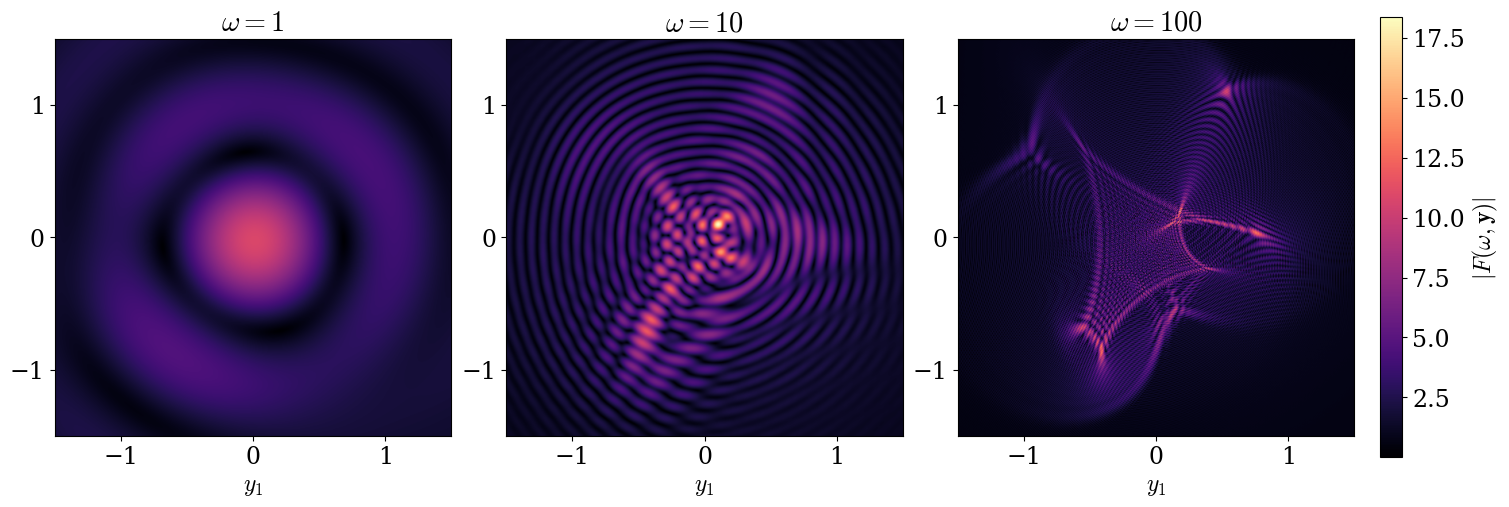

In [11]:
plot_randomSIS_w_grid_row_colorbars(
    n_sis=4,
    psi0=1.0,
    spread_list=(2.,),
    seed=123,
    w_list=(1.0, 10.0, 100.0),
    gl_nodes_per_dim=5000,
    min_physical_radius=10.0,
    nufft_tol=1e-13,
    numexpr_nthreads=64,
    y_extent=1.5,
    Ny=500,
    Nx=500,
    cmap="magma",
    font_size=17,
    verbose=False,
)

### 3.2 $|F(\omega)|$ vs $\omega$ at Fixed Source Positions

The amplification factor is computed at source positions $y \in \{0.25, 0.5, 1.0\}$
for 560 frequencies between $\omega = 0.1$ and $\omega = 50$.

[numexpr] using 1 threads (requested=1, MAX=1, cores=112)
[FresnelNUFFT3] x-domain path
  input prep:      0.0001s
  grouping:        0.0010s | groups=6
  adaptive R/h:  R in [7.07739, 70.7107] | n_gl in [1000, 6000], h in [0.0444288, 0.443892]
  quadrature:      0.3158s
  lens + base:     0.0000s
  scaling:         0.0000s
  alloc out:       0.0000s
  NUFFT total:    47.1260s
  tiling:        adaptive (tiles in [1, 72], max_points=16000000)
  workers:       up to 112 (nufft_nthreads=1)
  wall total:     52.6903s


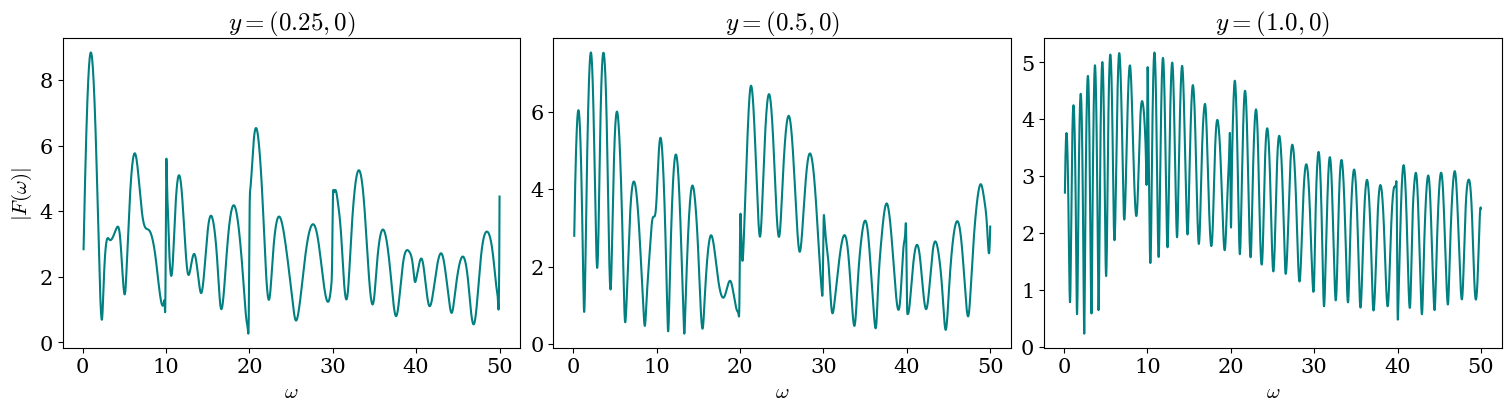

In [12]:
plot_random_sis_Fw_vs_w_panel(
    y_stars=(0.25, 0.5, 1.),
    w_grid=np.linspace(0.1, 50.0, 560),
    n_sis=4,
    psi0=1.0,
    spread=2.0,
    seed=123,
)

## 4. Ten SIS Sub-lenses — Random Positions

Ten SIS sub-lenses are drawn uniformly at random from a square of half-width 2.0
(centred on their centre of mass, `seed=123`).  With more sub-lenses the caustic
network becomes denser and the interference pattern richer.

### 4.1 2-D Magnification Maps

The amplification factor is evaluated on a 500 × 500 grid for
$\omega \in \{1, 10, 100\}$.

[subplot] spread=4, w=1, compute time=0.764 s
[subplot] spread=4, w=10, compute time=1.972 s
[subplot] spread=4, w=100, compute time=85.332 s


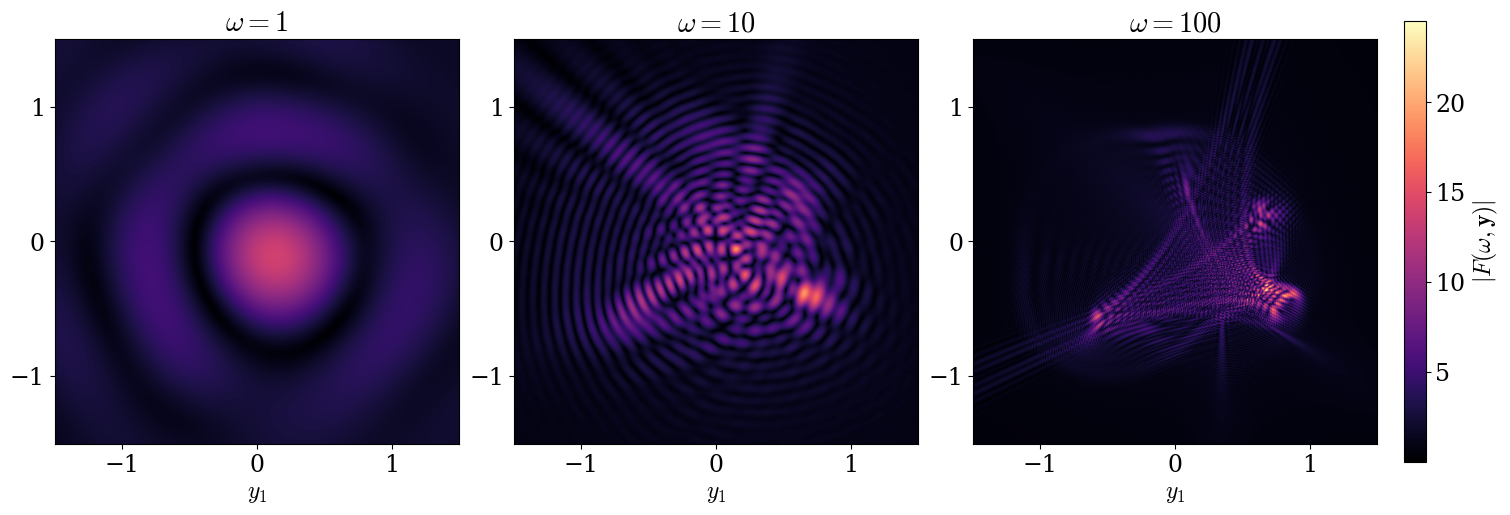

In [24]:
plot_randomSIS_w_grid_row_colorbars(
    n_sis=10,
    psi0=0.5,
    spread_list=(4.,),
    seed=123,
    w_list=(1.0, 10.0, 100.0),
    gl_nodes_per_dim=5000,
    min_physical_radius=10.0,
    nufft_tol=1e-13,
    numexpr_nthreads=64,
    y_extent=1.5,
    Ny=500,
    Nx=500,
    cmap="magma",
    font_size=17,
    verbose=False,
)

### 4.2 $|F(\omega)|$ vs $\omega$ at Fixed Source Positions

The amplification factor is computed at source positions $y \in \{0.25, 0.5, 1.0\}$
for 560 frequencies between $\omega = 0.1$ and $\omega = 50$.

[numexpr] using 1 threads (requested=1, MAX=1, cores=112)
[FresnelNUFFT3] x-domain path
  input prep:      0.0001s
  grouping:        0.0023s | groups=6
  adaptive R/h:  R in [7.07739, 70.7107] | n_gl in [1000, 6000], h in [0.0444288, 0.443892]
  quadrature:      0.3097s
  lens + base:     0.0000s
  scaling:         0.0000s
  alloc out:       0.0000s
  NUFFT total:    53.8365s
  tiling:        adaptive (tiles in [1, 72], max_points=16000000)
  workers:       up to 112 (nufft_nthreads=1)
  wall total:     59.4553s


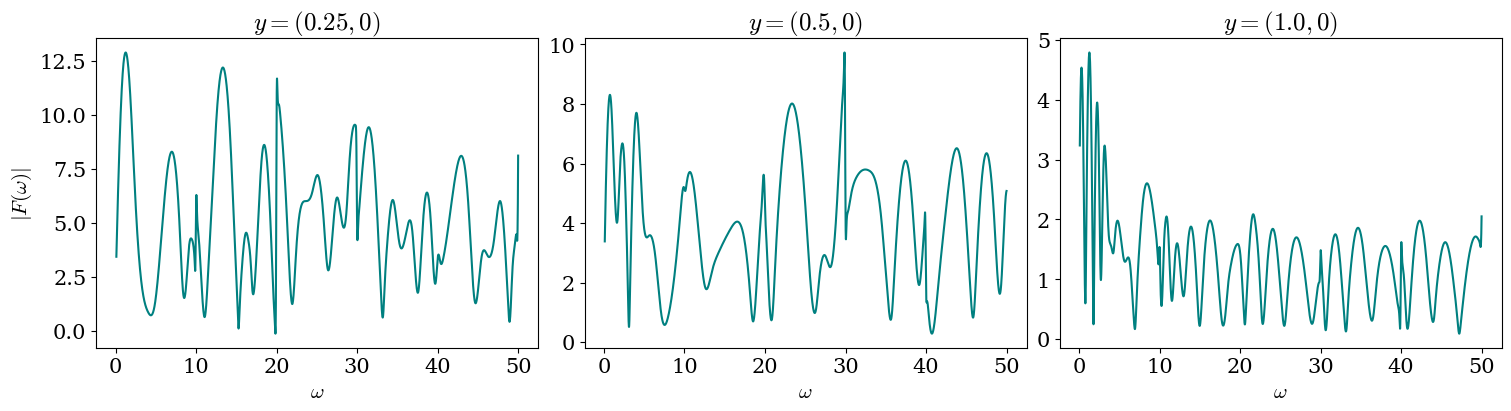

In [25]:
plot_random_sis_Fw_vs_w_panel(
    y_stars=(0.25, 0.5, 1.),
    w_grid=np.linspace(0.1, 50.0, 560),
    n_sis=10,
    psi0=0.5,
    spread=4.0,
    seed=123,
)